In [28]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import numbers
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown

## Нелинейная краевая задача

Аристова, Завьялова, Лобанов, XI.9.3

![title](11-9-3.png)

## Метод стрельбы

Перепишем условие в виде конечно-разностной схемы, выбросив временно условие на другом конце $y(1) = 2$:

$$\frac{y_{k+1} - 2y_k + y_{k-1}}{h^2} - kh\sqrt{y_k} = 0, \;\; k = 1, 2, 3, ..., N-1$$
$$y_0 = 0$$

Введем пристрелочный параметр: $\lambda_m = \frac{dy}{dx}|_{x = 0} = \frac{y_1 - y_0}{h}$, с начальным значением $\lambda_0 = \frac{y(1) - y(0)}{Nh}$. Мы свели задачу к Задаче Коши. 

Подгоняя параметр $\lambda_m$, можно вычислять $y_1$, значение которого требуется для вычисления по разностной схеме: 
$$y_1 = y_0 + h \lambda_m, \;\;y_0 = y(0) = 0$$

$$y_{k+1} = 2y_k - y_{k-1} + kh^3\sqrt{y_k} \;\; k = 1, 2, 3, ..., N-1$$

In [29]:
def Solve(lamb, h, N):
    __y = np.zeros(N + 1);
    __y[0] = 0
    __y[1] = __y[0] + lamb * h
    
    for __k in range(1, N):
        __y[__k + 1] = 2 * __y[__k] - __y[__k - 1] + __k * h**3 * np.sqrt(__y[__k])

    return __y

<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_133850/4147138855.py:29: SyntaxWarning: invalid escape sequence '\l'
  plt.scatter(n * h, y, s = 0.8, label=f'$\lambda_{{{it}}} = {lamb}$')


Финальное значение lambda = 1.8359375
Финальное y(2) = 1.9926374952489492 ~ 2


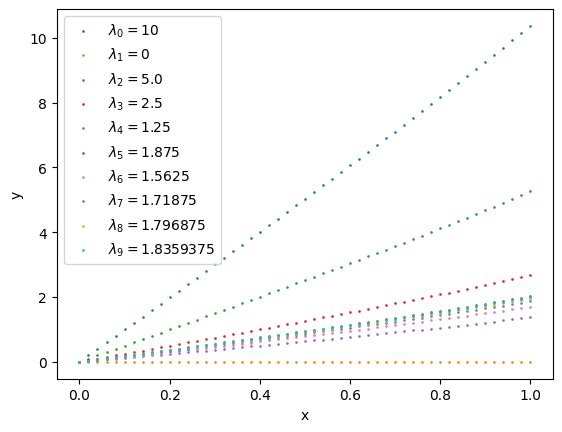

In [30]:
def HalfDivision( diff_fn, left, right, threshold, max_iters = 1000):
    assert diff_fn(left, 0)  < 0, 'Must be negative left side'
    assert diff_fn(right, 1) > 0, 'Must be positive right side'
    
    for __i in range(2, max_iters):
        mid = (right + left) / 2
        diff = diff_fn(mid, __i)
        if abs(diff) < threshold:
            return mid
        
        if diff > 0:
            right = mid
        elif diff < 0:
            left  = mid
        else:
            assert 0, 'Unreachable'

    assert 0, 'Cannot minimize'

def Diff(lamb, it = 0):
    y_left  = 0
    y_right = 2
    h = 0.02
    N = int(1 / h)
    
    n = np.linspace(0, N, N + 1, dtype = np.float64)
    y = Solve(lamb, h, N)
    
    plt.scatter(n * h, y, s = 0.8, label=f'$\lambda_{{{it}}} = {lamb}$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    return -(Solve(lamb, h, N)[-1] - y_right)

lamb = HalfDivision(diff_fn = Diff, right = 0, left = 10, threshold = 0.01)
y = Solve(lamb, 0.02, int(1 / 0.02))
print(f'Финальное значение lambda = {lamb}')
print(f'Финальное y(2) = {y[-1]} ~ 2')

y_shoot = y

## Метод квазилинеаризации Ньютона

Используем линеаризацию по Ньютону:
$$f(y^{m+1}) = f(y^{m}) + \frac{\partial f}{\partial y}(y^{m})\cdot(y^{m+1} - y^{m}),\;\; где \;\;f(y^m) = x\sqrt{y^m}$$
$$\frac{\partial f}{\partial y}(y^{m}) = \frac{x}{2\sqrt{y^m}}$$

Перепишем условие в виде конечно-разностной схемы:
$$\frac{y^{m+1}_{k+1} - 2y^{m+1}_k + y^{m+1}_{k-1}}{h^2} - x_k\sqrt{y^{m+1}_k} = 0, \;\; k = 1, 2, 3, ..., N-1$$

С учетом линеаризации выше, получим систему уравнений:

$$y^{m + 1}_0 = y(0) = 0$$

$$\frac{y^{m+1}_{k+1} - 2y^{m+1}_k + y^{m+1}_{k-1}}{h^2} - x_k\sqrt{y^{m}_k} - \frac{x_k}{2\sqrt{y^m_k}} \cdot(y^{m+1}_k - y^{m}_k) = 0, \;\; k = 1, 2, 3, ..., N-1$$

$$y^{m + 1}_N = y(1) = 2$$

Система выше линейна относительно $y^{m+1}$.

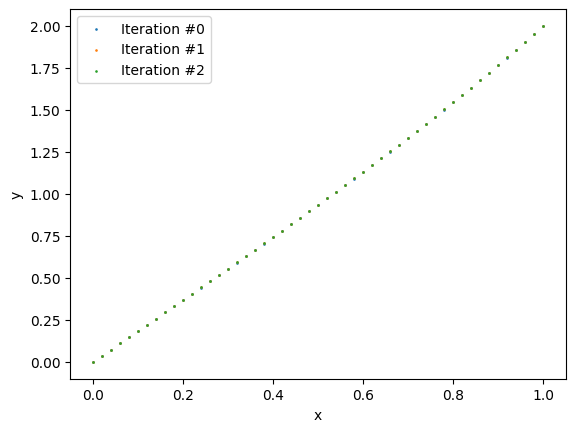

In [31]:
def SolveIteration(y, it, h, N):

    __A = np.zeros((N + 1, N + 1))
    for __i in range(0, N + 1):
        for __j in range(0, N + 1):
            
            if __i == 0:
                if __j == 0:
                    __A[__i][__j] = 1
                else:
                    __A[__i][__j] = 0
                continue
                
            if __i == N: 
                if __j == N:
                    __A[__i][__j] = 1
                else:
                    __A[__i][__j] = 0
                continue
    
            if __i == __j:       # Coef y_{k}
                __A[__i][__j] = -2 / h**2 - (__i * h) / (2 * np.sqrt(y[__i]))
            elif __i - 1 == __j: # Coef y_{k-1}
                __A[__i][__j] = 1 / h**2
            elif __i + 1 == __j: # Coef y_{k+1}
                __A[__i][__j] = 1 / h**2
            else:
                __A[__i][__j] = 0
    
    # Right
    __f = np.zeros(N + 1)
    __f[0] = 0 # Left end
    __f[N] = 2 # Right end
    for __k in range(1, N):
        __f[__k] = 1 / 2 * (__k * h) * np.sqrt(y[__k])
    
    __y = np.linalg.solve(__A, __f)

    __n = np.linspace(0, N, N + 1)
    plt.scatter(__n * h, __y, s = 0.8, label=f'Iteration #{it}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    return __y

h = 0.02
N = int(1 / h)

y = np.zeros(N + 1)
y_prev = np.full(N + 1, 1)
for i in range(1000):    
    y = SolveIteration(y_prev, i, h, N)
    if np.max(np.abs(y - y_prev)) < 0.0000001:
        break
    y_prev = y

y_newton = y

## Сравнение методов:

np.float64(0.007362504751050825)

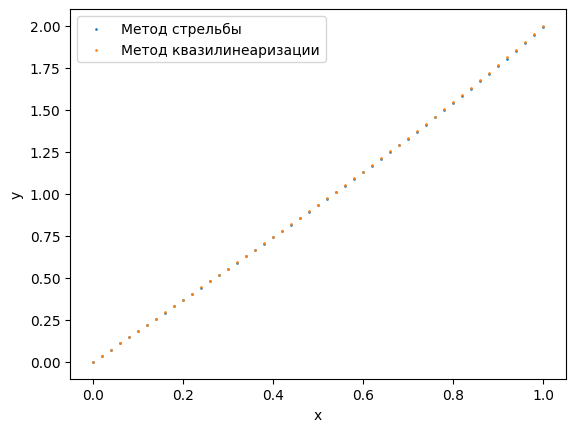

In [32]:
n = np.linspace(0, N, N + 1)

plt.scatter(n * h, y_shoot, s = 0.8, label=f'Метод стрельбы')
plt.scatter(n * h, y_newton, s = 0.8, label=f'Метод квазилинеаризации')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

np.max(np.abs(y_shoot - y_newton))

Аристова, Завьялова, Лобанов, XI.9.14

![title](11-9-16.png)

In [33]:
t_begin = 0
t_end   = 120
y_begin = 0
y_end   = 0

def f(t, y, dydt):
    assert isinstance(t,    numbers.Number), "t must be scalar."
    assert isinstance(y,    numbers.Number), "y must be scalar."
    assert isinstance(dydt, numbers.Number), "dydt must be scalar."

    return 1 - np.exp(y)

In [34]:
def classicRK4(t0, y0, h, f, n_iter=None, t_end=None):
    '''
    Classic 4th order Runge-Kutta method.
    Buther tableau: https://en.wikipedia.org/w/index.php?title=Runge%E2%80%93Kutta_methods&oldid=1189959645.
    '''

    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number"
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray"
    assert isinstance(h, numbers.Number), "h must be scalar number"
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray"
    assert n_iter is None or t_end is None, "specify n_iter or t_end"

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        k1 = f(t        , y)
        k2 = f(t + 1/2*h, y + 1/2*k1*h)
        k3 = f(t + 1/2*h, y + 1/2*k2*h)
        k4 = f(t +     h, y +     k3*h)
        y = y + h*(1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)
def shootingMethod(f, t_begin, y_begin, t_end, y_end, h,
                   precision=1e-5, max_iterations = 100,
                   a=None, df_dy=None, df_dydt=None):
    # Use slope as initial parameter if wasn't specified.
    if a == None:
        a = (y_end - y_begin) / (t_end - t_begin)

    # Use numerical derivatives if analytic weren't specified.
    if df_dy == None:
        df_dy = lambda t, y, dydt: (f(t, y + 1e-6, dydt) - f(t, y - 1e-6, dydt)) / (2e-6)
    if df_dydt == None:
        df_dydt = lambda t, y, dydt: (f(t, y, dydt + 1e-6) - f(t, y, dydt - 1e-6)) / (2e-6)

    for i in range(0, max_iterations):
        # print(f'{i=}, {a=}')

        # Solve pair of SODE simultaneously.
        # y_vec = [y, dy/dt, (dy/da), d/dt(dy/da)] = [y, z, u, v]
        f_vec = lambda t, y: np.array([
            y[1],
            f(t, y[0], y[1]),
            y[3],
            df_dy(t, y[0], y[1])*y[2] + df_dydt(t, y[0], y[1])*y[3]
        ])
        y0_vec = np.array([
            y_begin,
            a,
            0,
            1
        ])
        t, y_vec = classicRK4(t_begin, y0_vec, h, f_vec, t_end=t_end)

        y, z, u, v = list(zip(*y_vec))

        # Evaluate functional.
        F = y[-1] - y_end
        dFda = u[-1]
        # print(f"{F=}, {dFda=}")
        if np.abs(F) < precision:
            return t, y, a, i

        # Apply Newton method.
        a = a - F/dFda


==== Result ====
y[-1]=np.float64(-7.061851701628541e-06), a=np.float64(19.611799723090453), n_iters=4
y'(0)=19.611456296889433
y'(120)=18.92284168401023
==== Result ====
y[-1]=np.float64(1.2592017916701614e-06), a=np.float64(29.588698968826126), n_iters=3
y'(0)=29.588167477560265
y'(120)=29.38242619190285
==== Result ====
y[-1]=np.float64(-8.964476383432896e-09), a=np.float64(59.83833606546124), n_iters=2
y'(0)=59.83717350502452
y'(120)=59.11178210529708


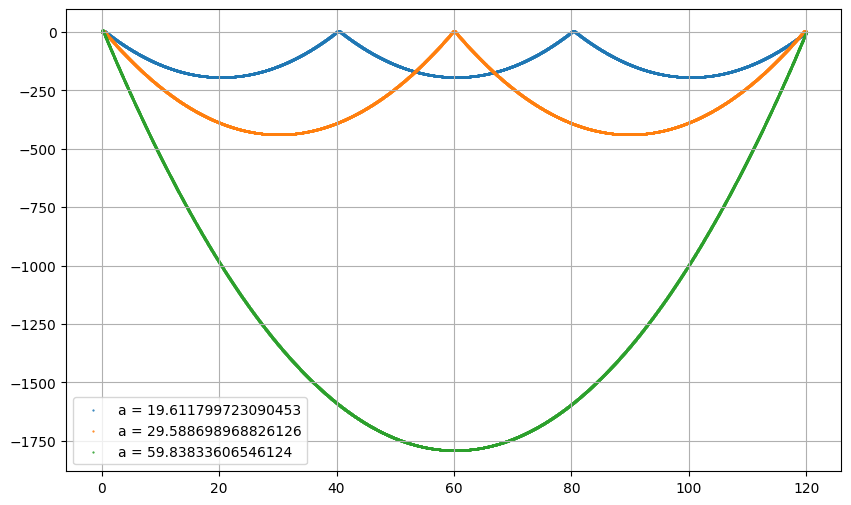

In [35]:
def displayResult(t, y, a, n_iters, draw=True):
    print(f"==== Result ====\n{y[-1]=}, {a=}, {n_iters=}")

    n = len(y)
    # t1 = 2
    # t2 = 3
    print(f"y'({t_begin})={(y[1] - y[0])/(t[1] - t[0])}")
    print(f"y'({t_end})={(y[-100] - y[-50])/(t[-100] - t[-50])}")
    print(f"================")

    if draw:
        plt.scatter(t, y, s=0.3, label=f"a = {a}")
        plt.grid()
        plt.legend()

draw = True
if draw:
    plt.figure(figsize=(10, 6))

t, y, a, n_iters = shootingMethod(f, t_begin, y_begin, t_end, y_end, a=19, h=0.01)
displayResult(t, y, a, n_iters, draw)
t, y, a, n_iters = shootingMethod(f, t_begin, y_begin, t_end, y_end, a=32, h=0.01)
displayResult(t, y, a, n_iters, draw)
t, y, a, n_iters = shootingMethod(f, t_begin, y_begin, t_end, y_end, a=61, h=0.01)
displayResult(t, y, a, n_iters, draw)